<div style="text-align: left; background-color:#E9F7EF; font-family:Arial; color:#526085; padding: 12px; line-height:1.25;border-radius:1px; margin-bottom: 0em; text-align: center; font-size: 58px;border-style: solid;border-color: dark green;">WEEK 6 - Support Vector Machine</div>


> **REQUIREMENT**
-	Apply all knowledge and techniques that you have learned for this
-	You must organize your notebook based on the Homework
-	Should not drop NA and missing value


In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(color_codes=True)
%matplotlib inline
from collections import Counter

import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.decomposition import PCA
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import joblib, scipy

In [2]:
df = pd.read_csv("C:\\Users\\laito\\OneDrive - VNU-HCMUS\\Jupyter Hub\\KHDL\\KHDL-MACHINE LEARNING\\Labs\\Week 06\\Churn-Rate-Prediction\\churn_rate_prediction.csv")
df.head()

,customer_id,Name,age,gender,security_no,region_category,membership_category,joining_date,joined_through_referral,referral_id,...,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,used_special_discount,offer_application_preference,past_complaint,complaint_status,feedback,churn_risk_score
0,fffe4300490044003600300030003800,Pattie Morrisey,18,F,XW0DQ7H,Village,Platinum Membership,2017-08-17,No,xxxxxxxx,...,300.63,53005.25,17.0,781.75,Yes,Yes,No,Not Applicable,Products always in Stock,2
1,fffe43004900440032003100300035003700,Traci Peery,32,F,5K0N3X1,City,Premium Membership,2017-08-28,?,CID21329,...,306.34,12838.38,10.0,NaN,Yes,No,Yes,Solved,Quality Customer Care,1
2,fffe4300490044003100390032003600,Merideth Mcmeen,44,F,1F2TCL3,Town,No Membership,2016-11-11,Yes,CID12313,...,516.16,21027.00,22.0,500.69,No,Yes,Yes,Solved in Follow-up,Poor Website,5
3,fffe43004900440036003000330031003600,Eufemia Cardwell,37,M,VJGJ33N,City,No Membership,2016-10-29,Yes,CID3793,...,53.27,25239.56,6.0,567.66,No,Yes,Yes,Unsolved,Poor Website,5
4,fffe43004900440031003900350030003600,Meghan Kosak,31,F,SVZXCWB,City,No Membership,2017-09-12,No,xxxxxxxx,...,113.13,24483.66,16.0,663.06,No,Yes,Yes,Solved,Poor Website,5


# **Data Analysis**
> Analyze and Preprocess data - Check if the dataset has missing values or has any other problem.

In [3]:
df.dtypes

customer_id                      object
Name                             object
age                               int64
gender                           object
security_no                      object
region_category                  object
membership_category              object
joining_date                     object
joined_through_referral          object
referral_id                      object
preferred_offer_types            object
medium_of_operation              object
internet_option                  object
last_visit_time                  object
days_since_last_login             int64
avg_time_spent                  float64
avg_transaction_value           float64
avg_frequency_login_days         object
points_in_wallet                float64
used_special_discount            object
offer_application_preference     object
past_complaint                   object
complaint_status                 object
feedback                         object
churn_risk_score                  int64


In [4]:
# from pandas_profiling import ProfileReport
# ProfileReport(df)

> Note: 
* According to Profile Report, some features has missing values as below
	* `region_category` has `5428` missing values - use `mode imputation`
	* `preferred_offer_types` has `288` missing values - `Handle: drop rows with nan`
	* `points_in_wallet` has `3443` missing value and high correlation - `mean imputation`
* Beside that, còn một số ô mang dữ liệu không ý nghĩa như some cells have meaningless data
	* `joined_through_referral` values (?)
	* `referral_id` (17846  values xxxxxxxx), 
	* `medium_of_operation` (?)
	* `avg_frequency_login_days` has value is 3522 `Error` and `imbalance`
	* `age` has data type like Unknown

# **Data Preprocessing**

In [5]:
df["churn_risk_score"].value_counts()

churn_risk_score
 3    10424
 4    10185
 5     9827
 2     2741
 1     2652
-1     1163
Name: count, dtype: int64

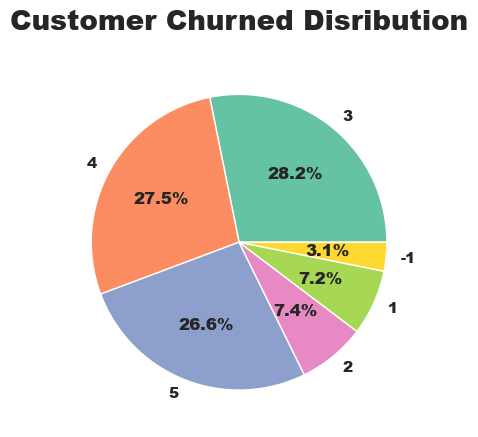

In [6]:
count = df["churn_risk_score"].value_counts()

plt.pie(count.values, labels=count.index, autopct="%1.1f%%",colors=sns.set_palette("Set2"),
        textprops={"fontweight":"black"})
plt.title("Customer Churned Disribution",fontweight="black",size=20,pad=20)
plt.show()

</div><div style="border-radius:10px; border:#808080 solid; padding: 15px; background-color: ##F0E68C ; font-size:100%; text-align:left">

<h3 align="left"><font color=brown>📊 Inference:</font></h3>

* There is **huge class-imbalance** which can lead to **bias in model performance.**
* So to **overcome** this **class-imbalance** we have to use **over-sampling technique** from **SMOTE**.

What is negative churn?

https://www.paddle.com/resources/negative-churn

Give u an example like this. Let's say you are running a software company that offers a subscription plan for 100$/month. At the beginning of the month, you have 100 customers and $10,000 revenue.

Throughout the month, know customer churn. 5 customers leave and cancel their subscriptions, resulting in a loss of $500. However, 10 existing customer upgrade their plans and you receive $1000

This represents growth from your existing customers and contributes to overall revenue expansion without acquiring new customers.

In this dataset, what is the reason?
> There is a huge difference between some of the classes in the target(churn_risk_score) column.(-1,1 and 2 are quite less as compared 3,4,5). We will handle it when creating the model

In [7]:
print('Total', df.shape[0], 'samples')
(df.isnull().sum() / len(df) * 100).to_frame().rename(columns={0:"Total No. of Missing Values"})

Total 36992 samples


,Total No. of Missing Values
customer_id,0.000000
Name,0.000000
age,0.000000
gender,0.000000
security_no,0.000000
region_category,14.673443
membership_category,0.000000
joining_date,0.000000
joined_through_referral,0.000000
referral_id,0.000000


In [8]:
df[df.duplicated()]

,customer_id,Name,age,gender,security_no,region_category,membership_category,joining_date,joined_through_referral,referral_id,...,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,used_special_discount,offer_application_preference,past_complaint,complaint_status,feedback,churn_risk_score


In [9]:
df.describe(include="object").T

,count,unique,top,freq
customer_id,36992,36992,fffe4300490044003600300030003800,1
Name,36992,36992,Pattie Morrisey,1
gender,36992,3,F,18490
security_no,36992,36992,XW0DQ7H,1
region_category,31564,3,Town,14128
membership_category,36992,6,Basic Membership,7724
joining_date,36992,1096,2015-06-02,55
joined_through_referral,36992,3,No,15839
referral_id,36992,11359,xxxxxxxx,17846
preferred_offer_types,36704,3,Gift Vouchers/Coupons,12349


> Note: 
* Drop unnecessary features which do not have any insights to predict churn risk score like  `customer_id`, `Name`, `security_no`, `joining_date`, `referral_id`, `last_visit_time` 

In [10]:
from sklearn.impute import SimpleImputer
def preprocessing_data(df):
    """
    Preprocess your data (eg. Drop null datapoints or fill missing data)
    :param df: pandas DataFrame
    :return: pandas DataFrame
    """
    # Todo: preprocess data
    
    # Drop unnecessary column
    df = df.drop(columns=['customer_id', 'Name', 'security_no', 'referral_id', 'gender', 'joining_date', 'last_visit_time'], axis = 1)
    
    df['avg_frequency_login_days'] = pd.to_numeric(df['avg_frequency_login_days'], errors='coerce')
    # df['churn_risk_score'] = df['churn_risk_score'].astype('category')
    
    df = df[df['churn_risk_score'] != -1]
    
    # Fill nan in preferred_offer_types by mode
    imputer_mode = SimpleImputer(strategy='most_frequent')
    df[['region_category']] = imputer_mode.fit_transform(df[['region_category']])
    df[['preferred_offer_types']] = imputer_mode.fit_transform(df[['preferred_offer_types']])
    
    # Fill nan by mean of points in wallet
    imputer_mean = SimpleImputer(strategy = 'mean')
    df[['points_in_wallet']] = imputer_mean.fit_transform(df[['points_in_wallet']])
    df[['avg_frequency_login_days']] = imputer_mean.fit_transform(df[['avg_frequency_login_days']])
    
    # df['gender'] = df['gender'].replace({'Unknown': df['gender'].mode()[0]})
    
    return df

In [11]:
# no effect to the original data
df = preprocessing_data(df.copy())

joined_through_referral: join by invitation by friends or family



In [12]:
df.isnull().sum()

age                             0
region_category                 0
membership_category             0
joined_through_referral         0
preferred_offer_types           0
medium_of_operation             0
internet_option                 0
days_since_last_login           0
avg_time_spent                  0
avg_transaction_value           0
avg_frequency_login_days        0
points_in_wallet                0
used_special_discount           0
offer_application_preference    0
past_complaint                  0
complaint_status                0
feedback                        0
churn_risk_score                0
dtype: int64

# **Exploratory Data Analysis**

In [13]:
categorical_cols = [feature for feature in df.columns if df[feature].dtype == 'O']
numerical_cols = [feature for feature in df.columns if df[feature].dtype != 'O']
outlier_columns = ['avg_time_spent','avg_transaction_value', 'avg_frequency_login_days', 'points_in_wallet']

In [14]:
# categorical_cols.remove('joining_date')
# categorical_cols.remove('last_visit_time')

In [15]:
categorical_cols

['region_category',
 'membership_category',
 'joined_through_referral',
 'preferred_offer_types',
 'medium_of_operation',
 'internet_option',
 'used_special_discount',
 'offer_application_preference',
 'past_complaint',
 'complaint_status',
 'feedback']

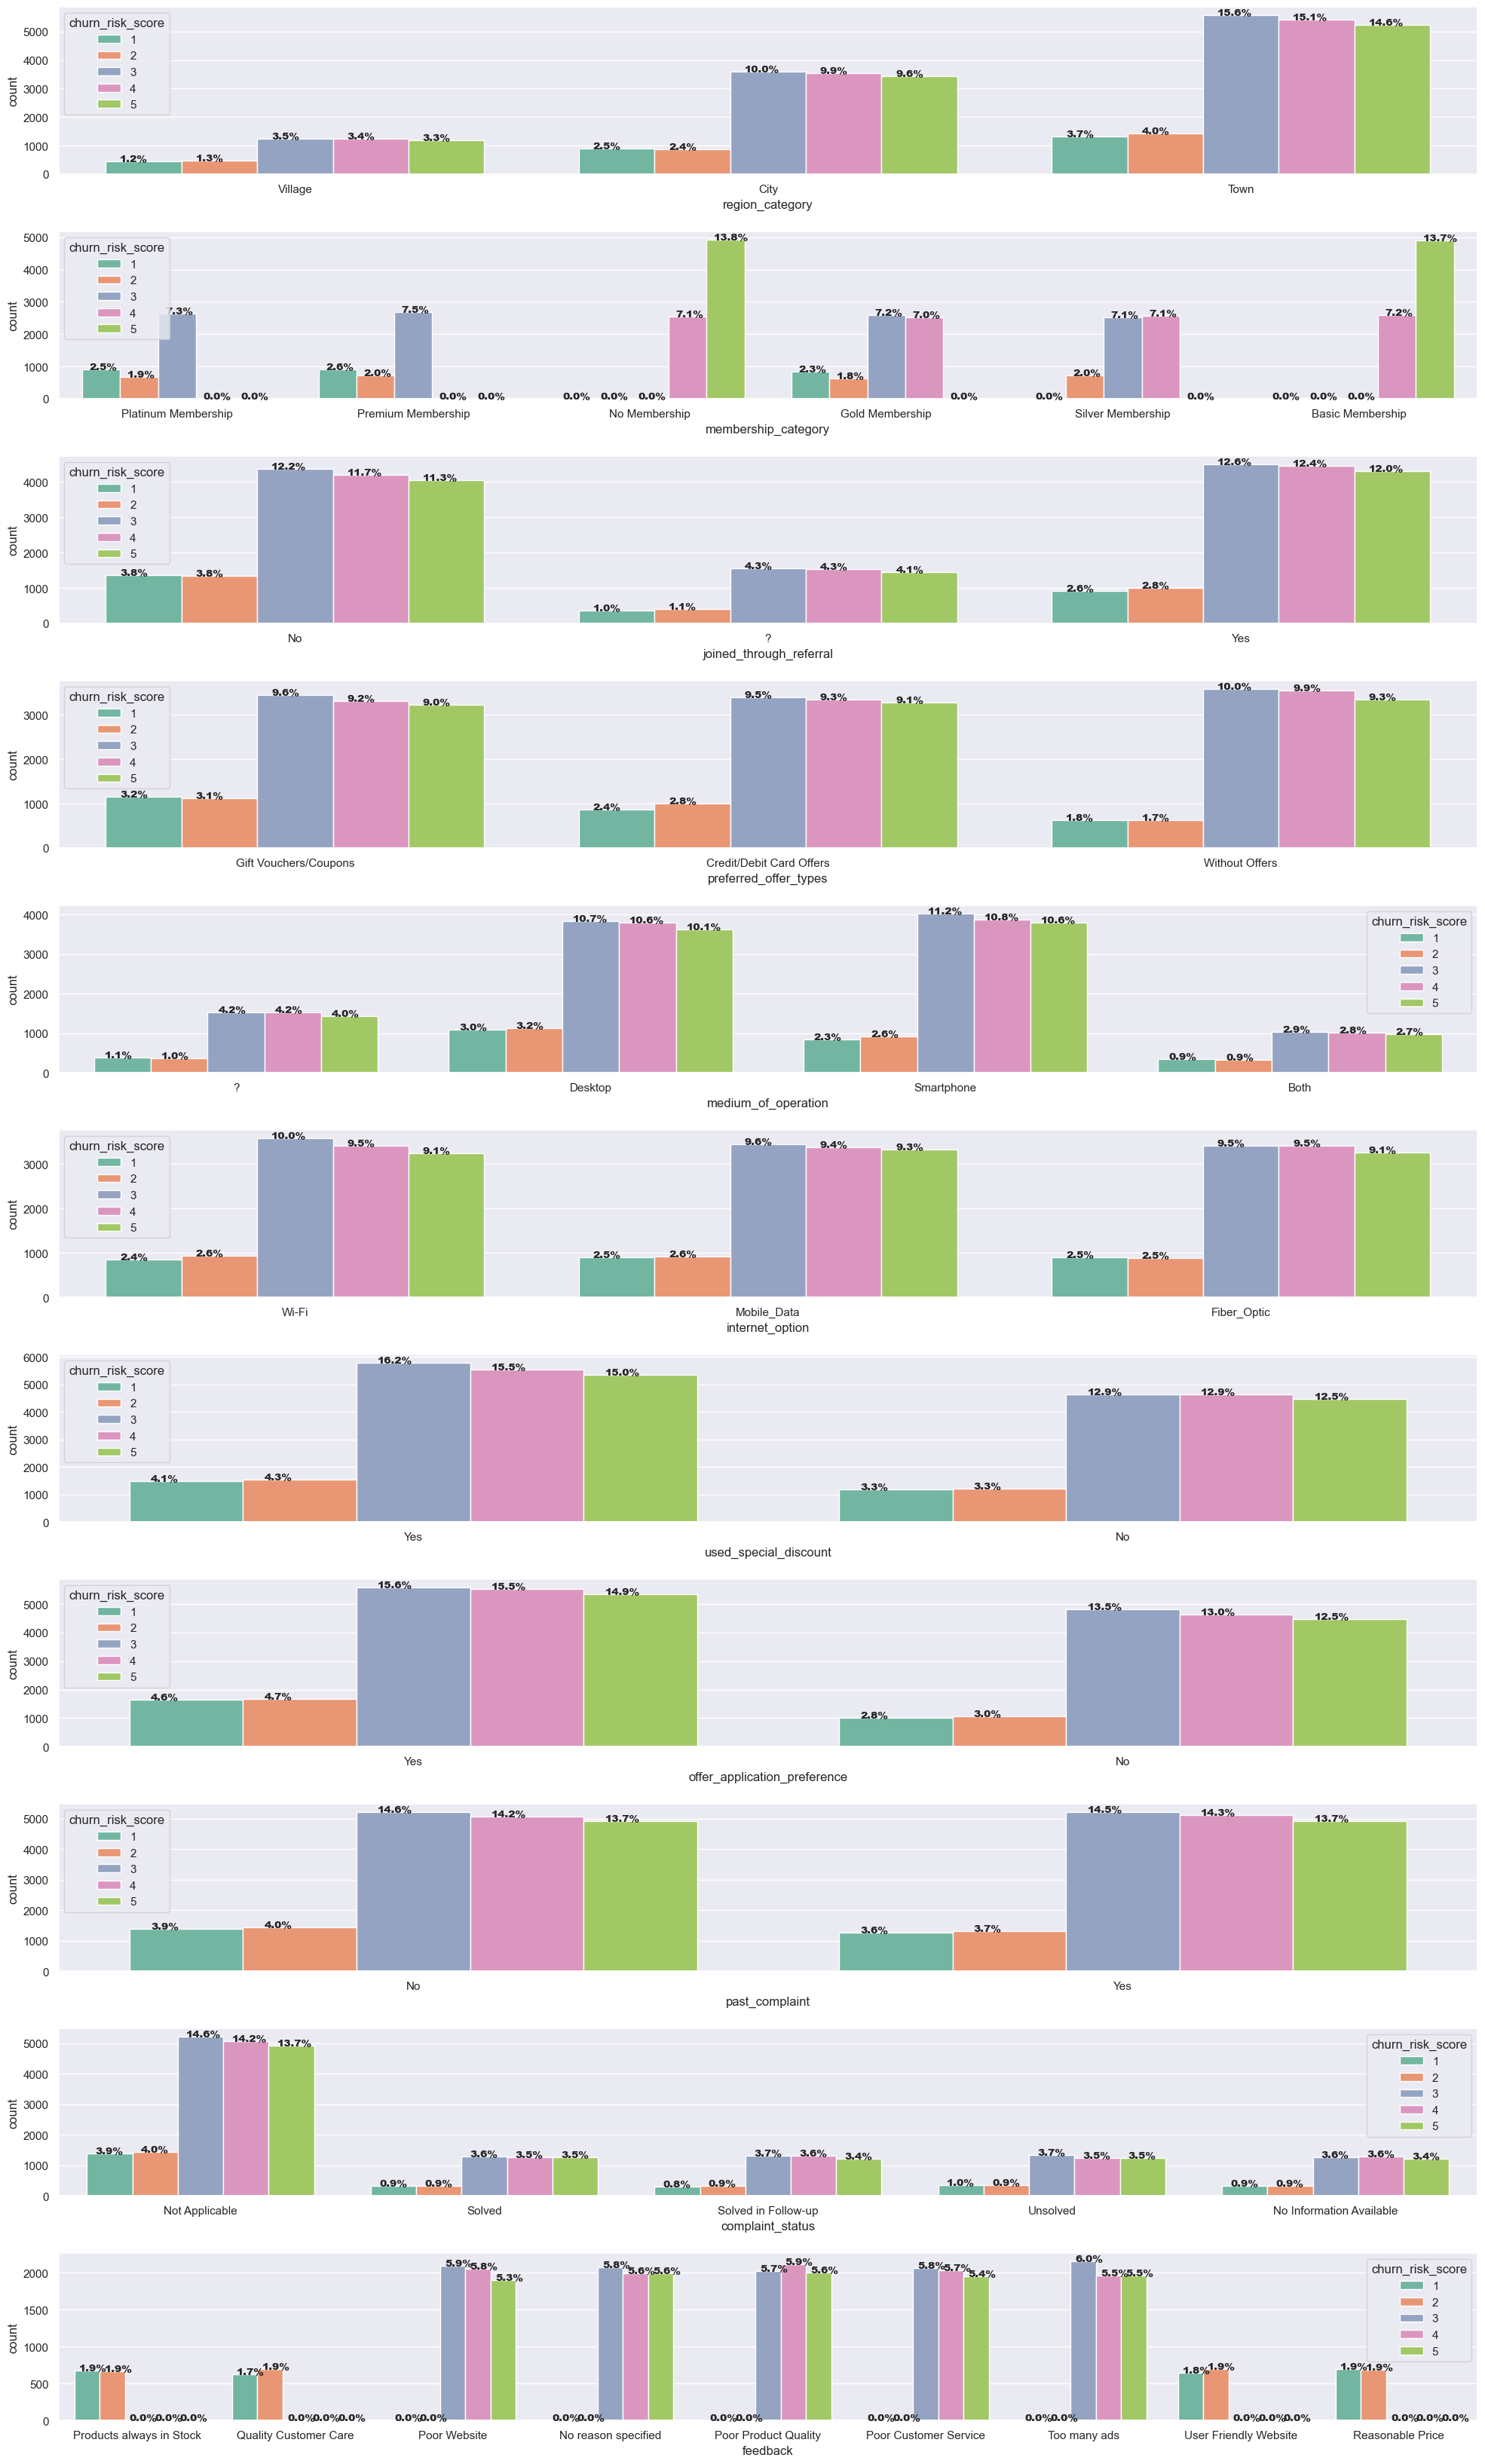

In [16]:
fig, axes = plt.subplots(len(categorical_cols), 1 , figsize = (20, 3 * len(categorical_cols)), sharex = False, sharey = False)
for i, column in enumerate(categorical_cols):
  ax = sns.countplot(x=column, data=df, ax=axes[i], hue="churn_risk_score", palette="Set2")
  for value in ax.patches:
        percentage = "{:.1f}%".format(100*value.get_height()/len(df[column]))
        x = value.get_x() + value.get_width() / 2 - 0.05
        y = value.get_y() + value.get_height()
        ax.annotate(percentage, (x,y), fontweight="black",size=10)
plt.tight_layout(pad=1.5)
plt.show()

* Membership: The ratio of customers have no membership or low membership, will have a low churn rate score 
* joined_through_referral: what is `?`. Maybe they found it by coincidence and stick to using it

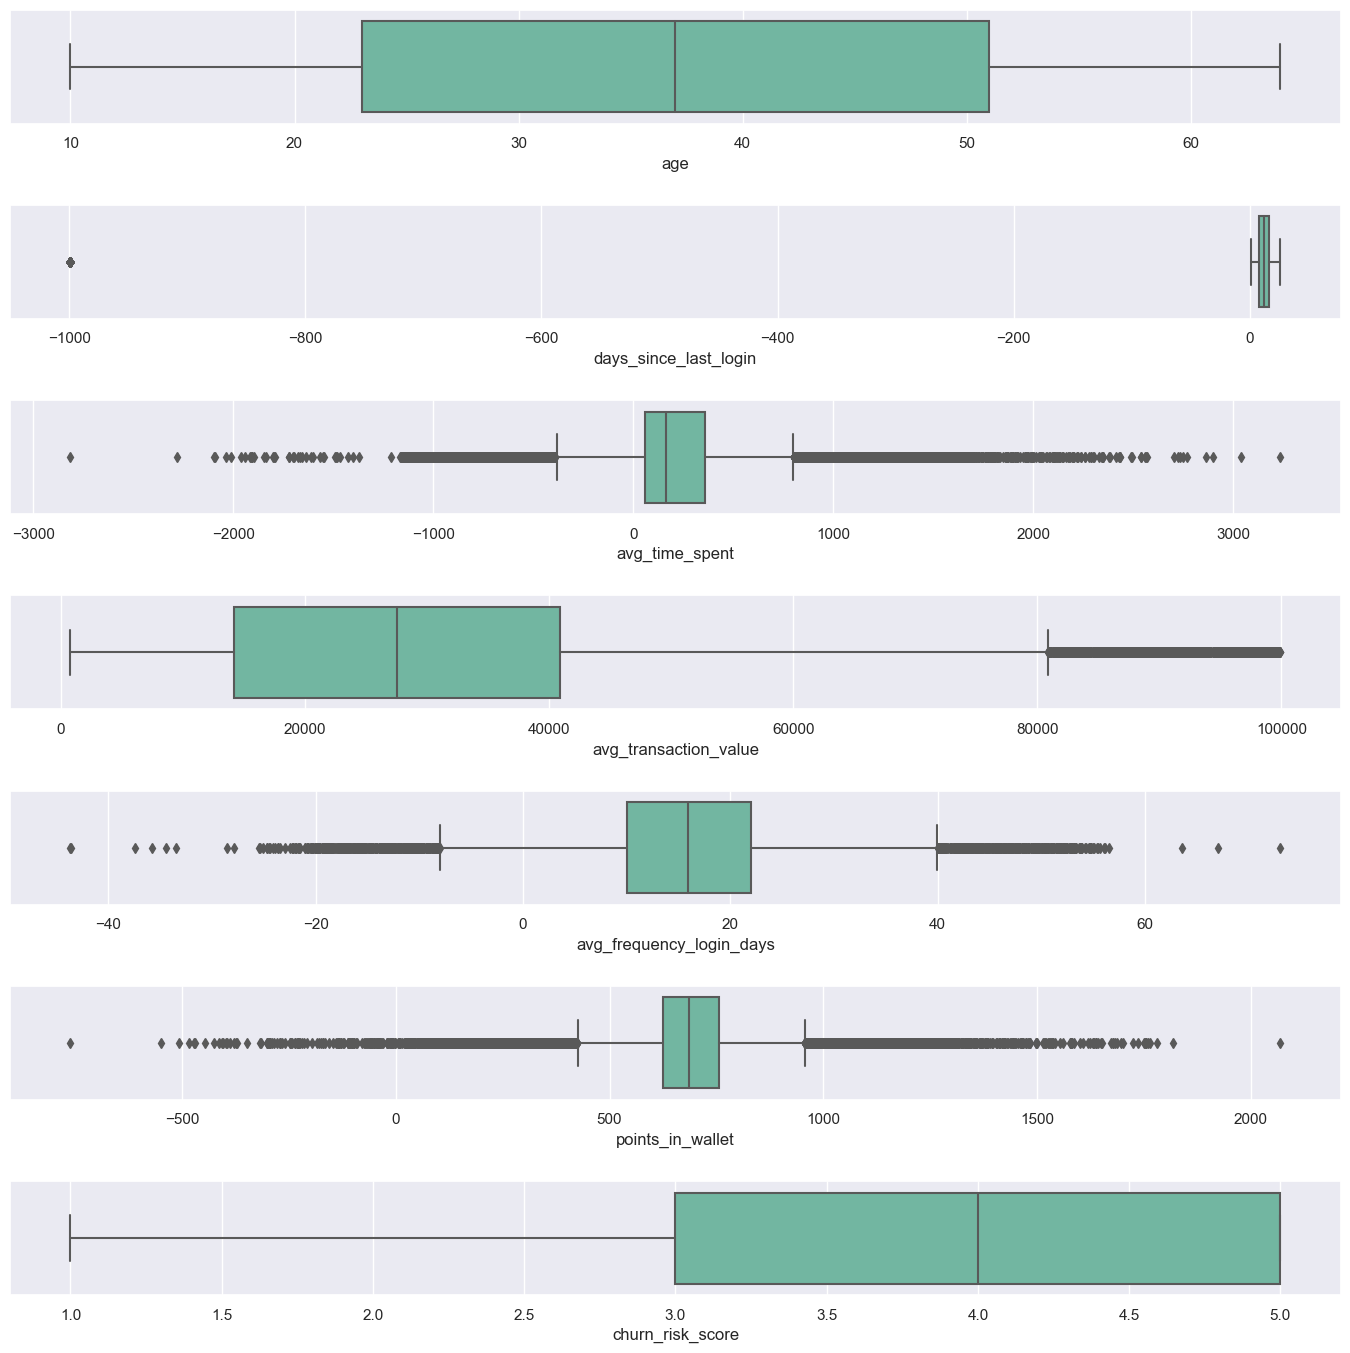

In [17]:
fig, axes=plt.subplots(len(numerical_cols), 1, figsize=(14, 2*len(numerical_cols)),sharex=False,sharey=False)

for i, column in enumerate(numerical_cols):
    sns.boxplot(x=column,data=df,palette='Set2',ax=axes[i])
plt.tight_layout(pad=2.0)

> Why so many negative numbers in features which is average of time. It will be make sense if the number more than 0. Damnn

## **Handle Outliers**

In [18]:
outlier_columns = ['days_since_last_login','avg_time_spent','avg_transaction_value','points_in_wallet']
for col in outlier_columns:
    lower_limit, upper_limit = df[col].quantile([0.25,0.75])
    IQR = upper_limit - lower_limit
    lower_whisker = lower_limit - 1.5 * IQR
    upper_whisker = upper_limit + 1.5 * IQR
    df[col] = np.where(df[col]<lower_whisker, lower_whisker, np.where(df[col]>upper_whisker, upper_whisker,df[col]))

## **Visualization after Outlier Processing**

In [19]:
def numerical_plot(column, df):
    plt.figure(figsize=(13,6))
    plt.subplot(1,2,1)
    # sns.histplot(data = df, x = column, hue = 'churn_risk_score', kde = True, palette = 'Set2')
    sns.kdeplot(data = df, x = column, hue = 'churn_risk_score', palette='Set2', shade = True)
    plt.title(f"Distribution of {column} by Churn Status",fontweight="black",pad=20,size=11)
    
    plt.subplot(1,2,2)
    sns.boxenplot(data = df, x = column)
    plt.title(f"Distribution of {column} by Churn Status",fontweight="black",pad=20,size=11)
    plt.tight_layout()
    plt.show()

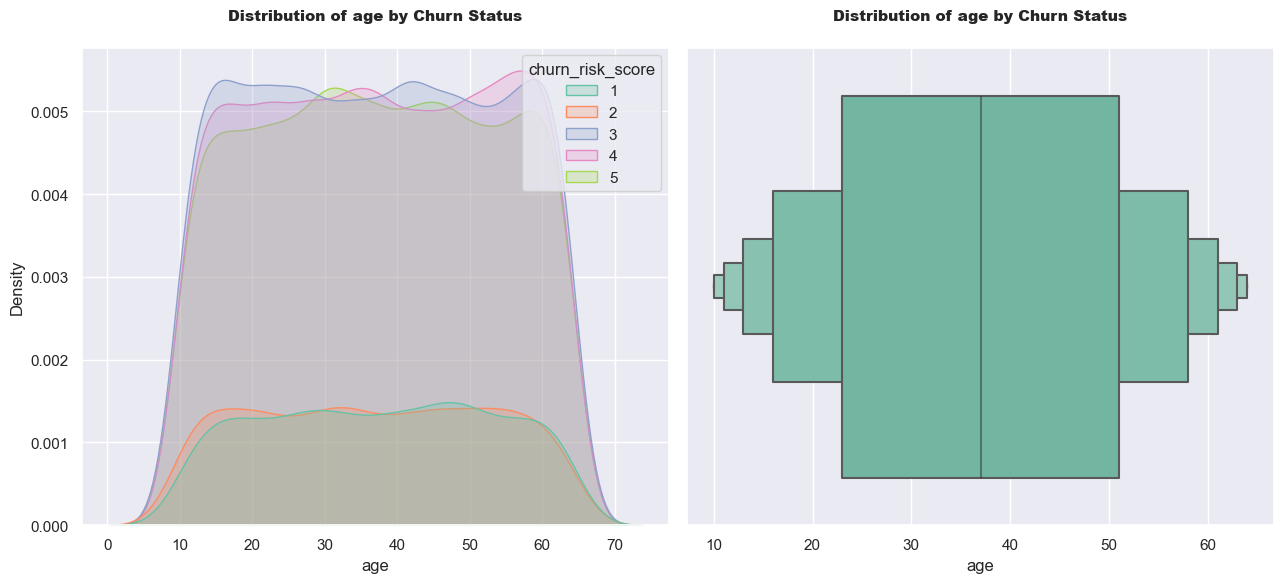

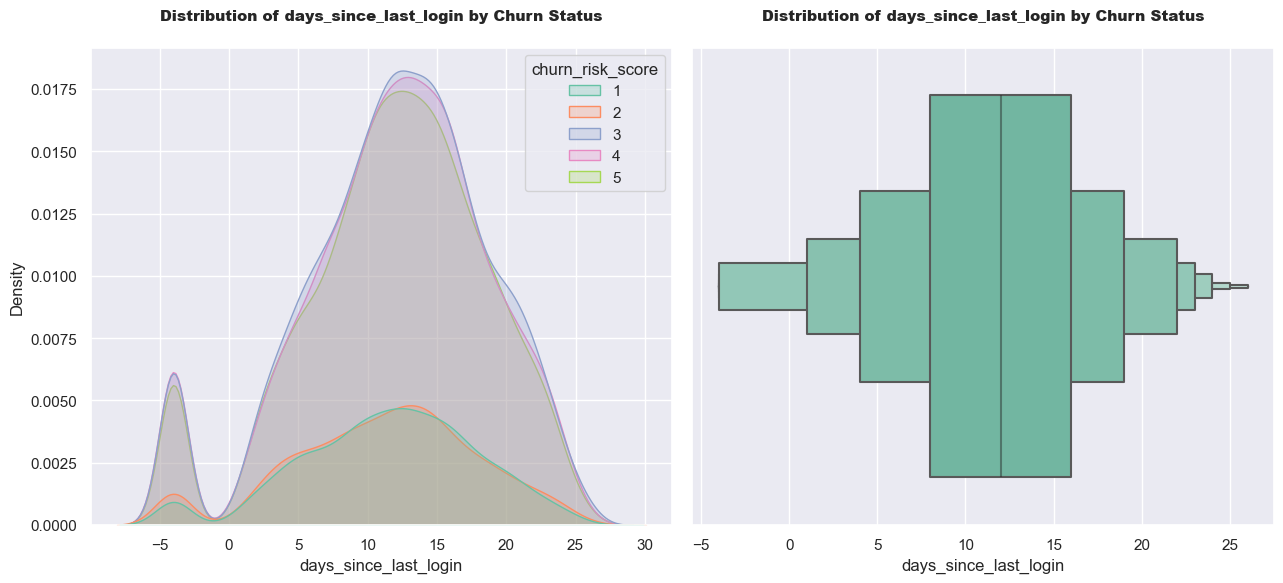

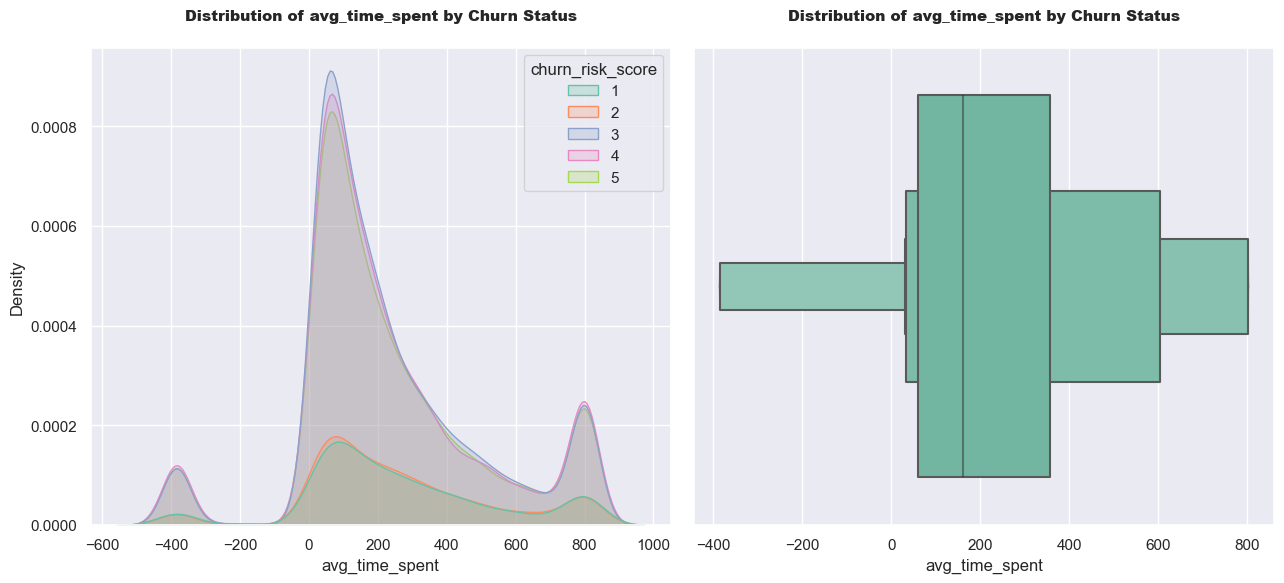

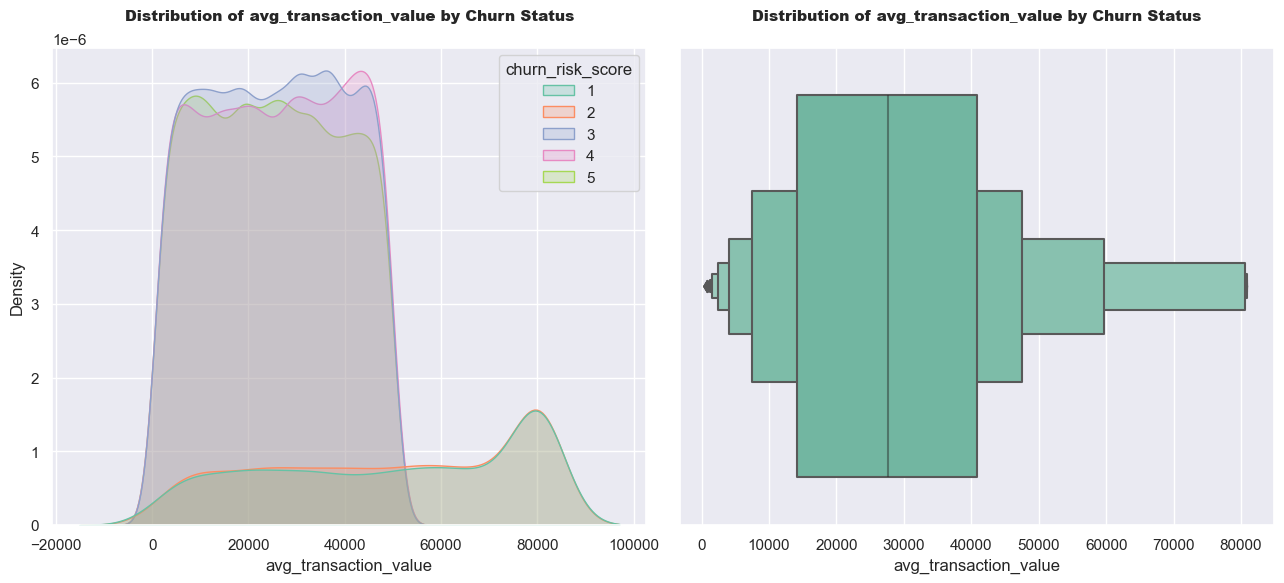

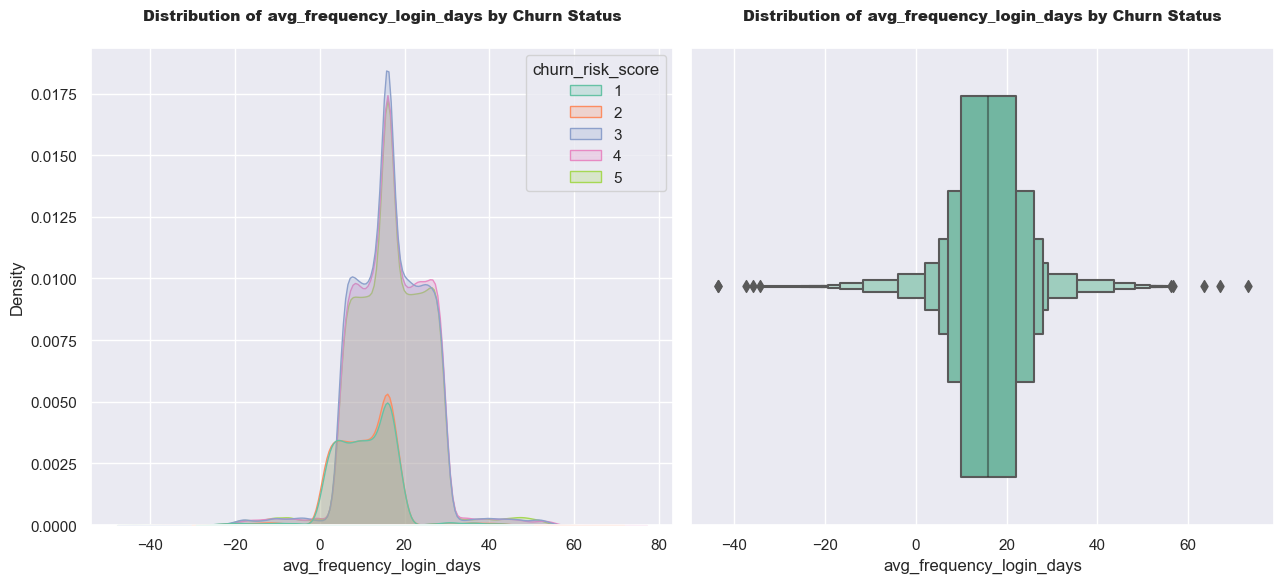

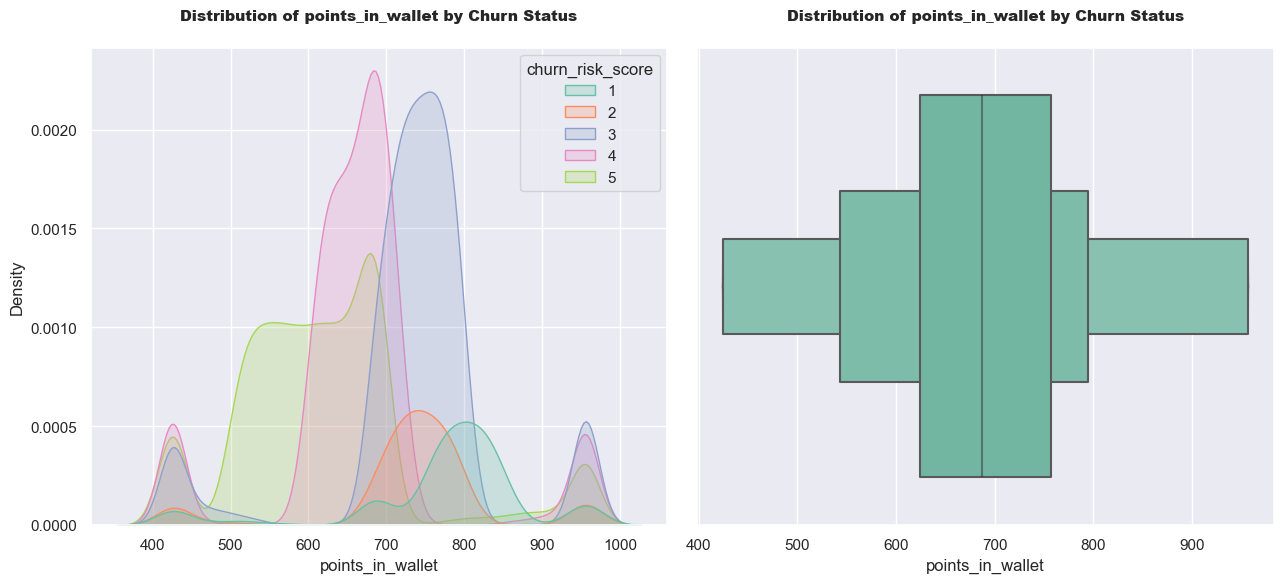

<Figure size 640x480 with 0 Axes>

In [20]:
for column in numerical_cols[:-1]:
  numerical_plot(column, df)
plt.tight_layout(pad=1.0)

> As we can see in the previous figures, lines 3, 4, and 5 have a higher density than others. Then we replace those churn risk score which has values [3, 4, 5] with yes and the others turn into 0, 1, 2

In [21]:
# df['churn_risk_score'] = df['churn_risk_score'].replace({-1: 0, 1: 0, 2: 0, 3: 1, 4: 1, 5: 1})

# **Feature Extraction**

In [22]:
# df['joining_date'] = pd.to_datetime(df['joining_date'])

In [23]:
# df['joining_day'] = df['joining_date'].dt.day
# df['joining_year'] = df['joining_date'].dt.year
# df['joining_month'] = df['joining_date'].dt.month
# df['joining_day_of_week'] = df['joining_date'].dt.dayofweek
# df['is_joining_day_weekend'] = np.where(df['joining_date'].isin([5,6]),1,0)

In [24]:
# df['last_visit_time'] = pd.to_datetime(df['last_visit_time'])

In [25]:
# df['last_visit_hour'] = df['last_visit_time'].dt.hour
# df['last_visit_min'] = df['last_visit_time'].dt.minute
# df['last_visit_second'] = df['last_visit_time'].dt.second

In [26]:
# df.drop(['joining_date','last_visit_time'],axis=1,inplace=True)
# df.drop(['last_visit_time'],axis=1,inplace=True)

# **Feature Exploration**

In [27]:
def plot_pie_chart(data):
    values = data.value_counts().values
    labels = data.value_counts().keys()
    plt.figure(figsize=(8,6),dpi=100)
    plt.pie(values,labels=labels,shadow=True,autopct='%1.2f%%')
    plt.show();

region_category :


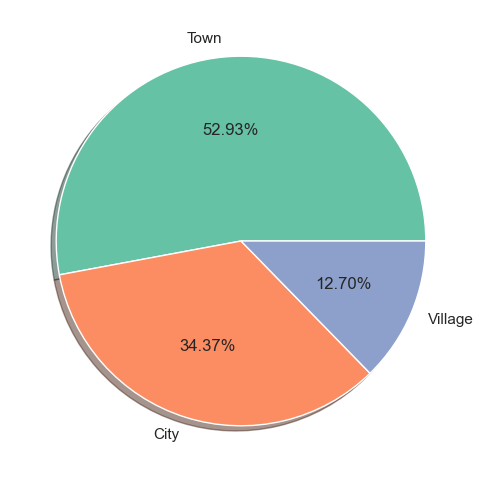

membership_category :


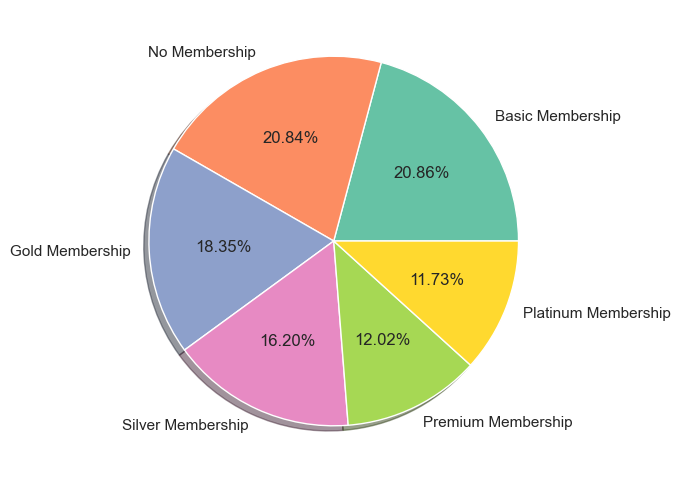

joined_through_referral :


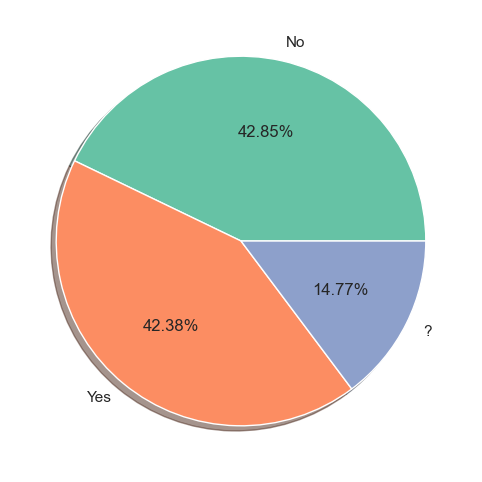

preferred_offer_types :


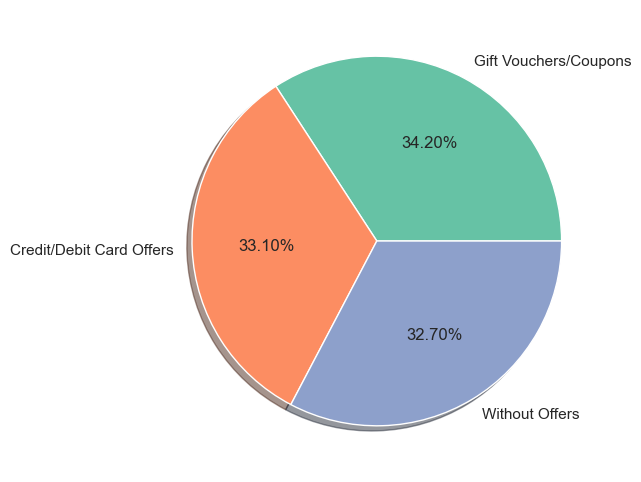

medium_of_operation :


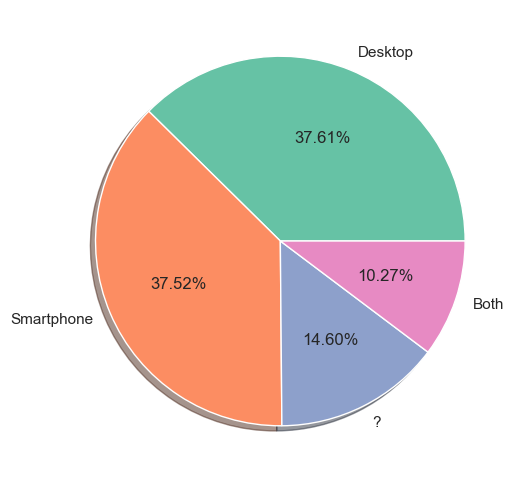

internet_option :


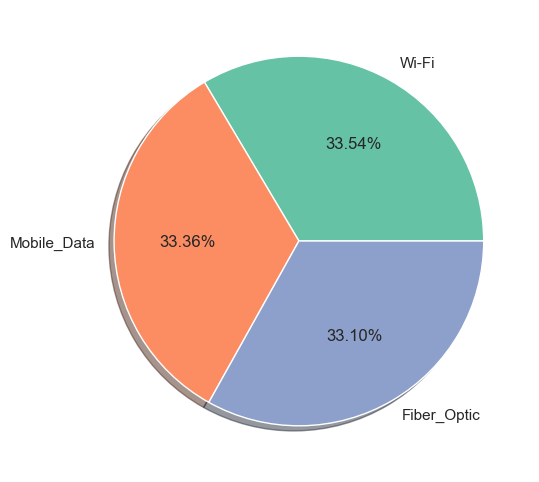

used_special_discount :


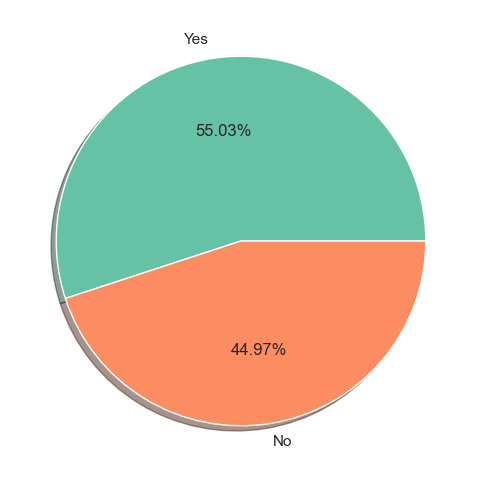

offer_application_preference :


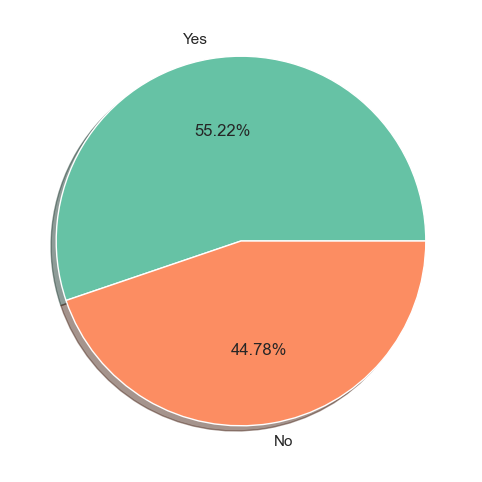

past_complaint :


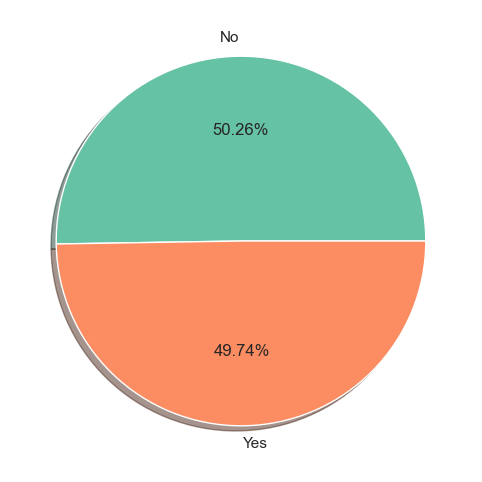

complaint_status :


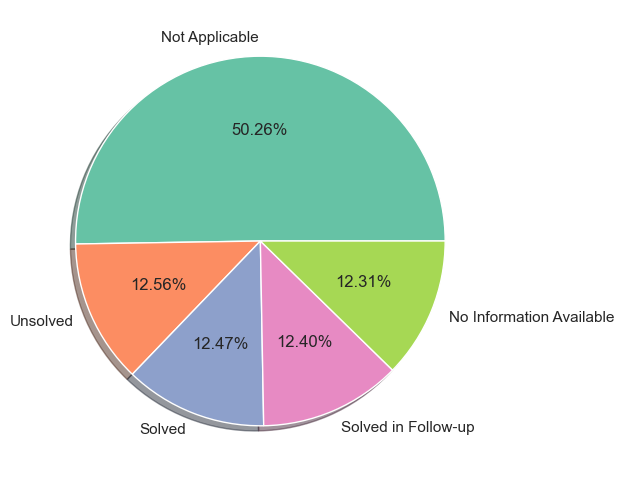

feedback :


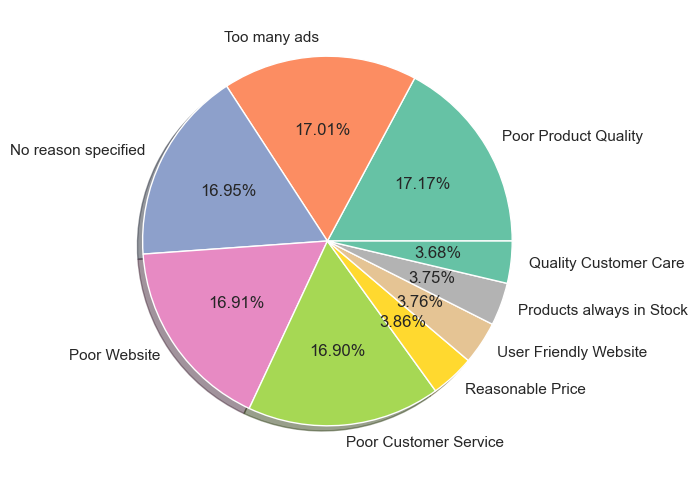

In [28]:
for col in categorical_cols:
  print(col,':')
  plot_pie_chart(df[col])

# **Feature Engineering**

In [29]:
df['avg_frequency_login_days'].value_counts().to_frame()

,count
avg_frequency_login_days,
15.963040,3419
13.000000,1361
8.000000,1326
19.000000,1319
14.000000,1315
...,...
20.608633,1
55.376272,1
1.962198,1


In [30]:
# def convert_categorical_to_numerical(df, col):
#   df[col] = df[col].astype("category").cat.codes

def apply_feature_engineering(df):
    # Todo: Normalize your data
    # for feature in categorical_cols:
    #     convert_categorical_to_numerical(df, feature)
    
    # df.gender.replace(['F','M','Unknown'],[0,1,-1],inplace=True)
    # df.gender = df.gender.astype(int)
    
    df.joined_through_referral.replace(['No','Yes','?'],[0,1,-1],inplace=True)
    df.joined_through_referral = df.joined_through_referral.astype(int)
    
    df.medium_of_operation.replace('?','Unknown',inplace=True)
    
    df.complaint_status.replace(['Solved','Solved in Follow-up'],'Solved',inplace=True)
    df.complaint_status.replace(['Not Applicable','No Information Available'],'Unknown',inplace=True)
    df.complaint_status.replace(['Unknown','Solved','Unsolved'],[-1,1,0],inplace=True)
    df.complaint_status = df.complaint_status.astype(int)
    
    df.feedback.replace(['Poor Product Quality','Too many ads','Poor Website','Poor Customer Service'],-1,inplace=True)
    df.feedback.replace(['Reasonable Price','User Friendly Website','Products always in Stock','Quality Customer Care'],1,inplace=True)
    df.feedback.replace('No reason specified',0,inplace=True)
    df.feedback = df.feedback.astype(int)
    
    df.offer_application_preference.replace(['Yes','No'],[1,0],inplace=True)
    df.offer_application_preference = df.offer_application_preference.astype(int)
    
    df.past_complaint.replace(['Yes','No'],[1,0],inplace=True)
    df.past_complaint = df.past_complaint.astype(int)
    
    df.joined_through_referral.replace(['Yes','No'],[1,0],inplace=True)
    df.joined_through_referral = df.joined_through_referral.astype(int)
    
    df.used_special_discount.replace(['Yes','No'],[1,0],inplace=True)
    df.used_special_discount = df.used_special_discount.astype(int)
    
    # Drop avg_time < 0
    df = df[df['avg_time_spent']>0]
    df = df[df['days_since_last_login']>0]
    
    # df.drop('is_joining_day_weekend',axis=1,inplace=True)
    
    dummy_col = ['region_category', 'membership_category','preferred_offer_types', 'medium_of_operation', 'internet_option']

    for col in dummy_col:
        print(col,':')
        encoder = LabelEncoder()
        df[col] = encoder.fit_transform(df[col])
        df[col] = df[col].astype(int)
        print(encoder.classes_, encoder.transform(encoder.classes_))
    
    return df
df = apply_feature_engineering(df)


region_category :
['City' 'Town' 'Village'] [0 1 2]
membership_category :
['Basic Membership' 'Gold Membership' 'No Membership'
 'Platinum Membership' 'Premium Membership' 'Silver Membership'] [0 1 2 3 4 5]
preferred_offer_types :
['Credit/Debit Card Offers' 'Gift Vouchers/Coupons' 'Without Offers'] [0 1 2]
medium_of_operation :
['Both' 'Desktop' 'Smartphone' 'Unknown'] [0 1 2 3]
internet_option :
['Fiber_Optic' 'Mobile_Data' 'Wi-Fi'] [0 1 2]


> `Unknown` maybe is any device that can access this thing

<AxesSubplot:>

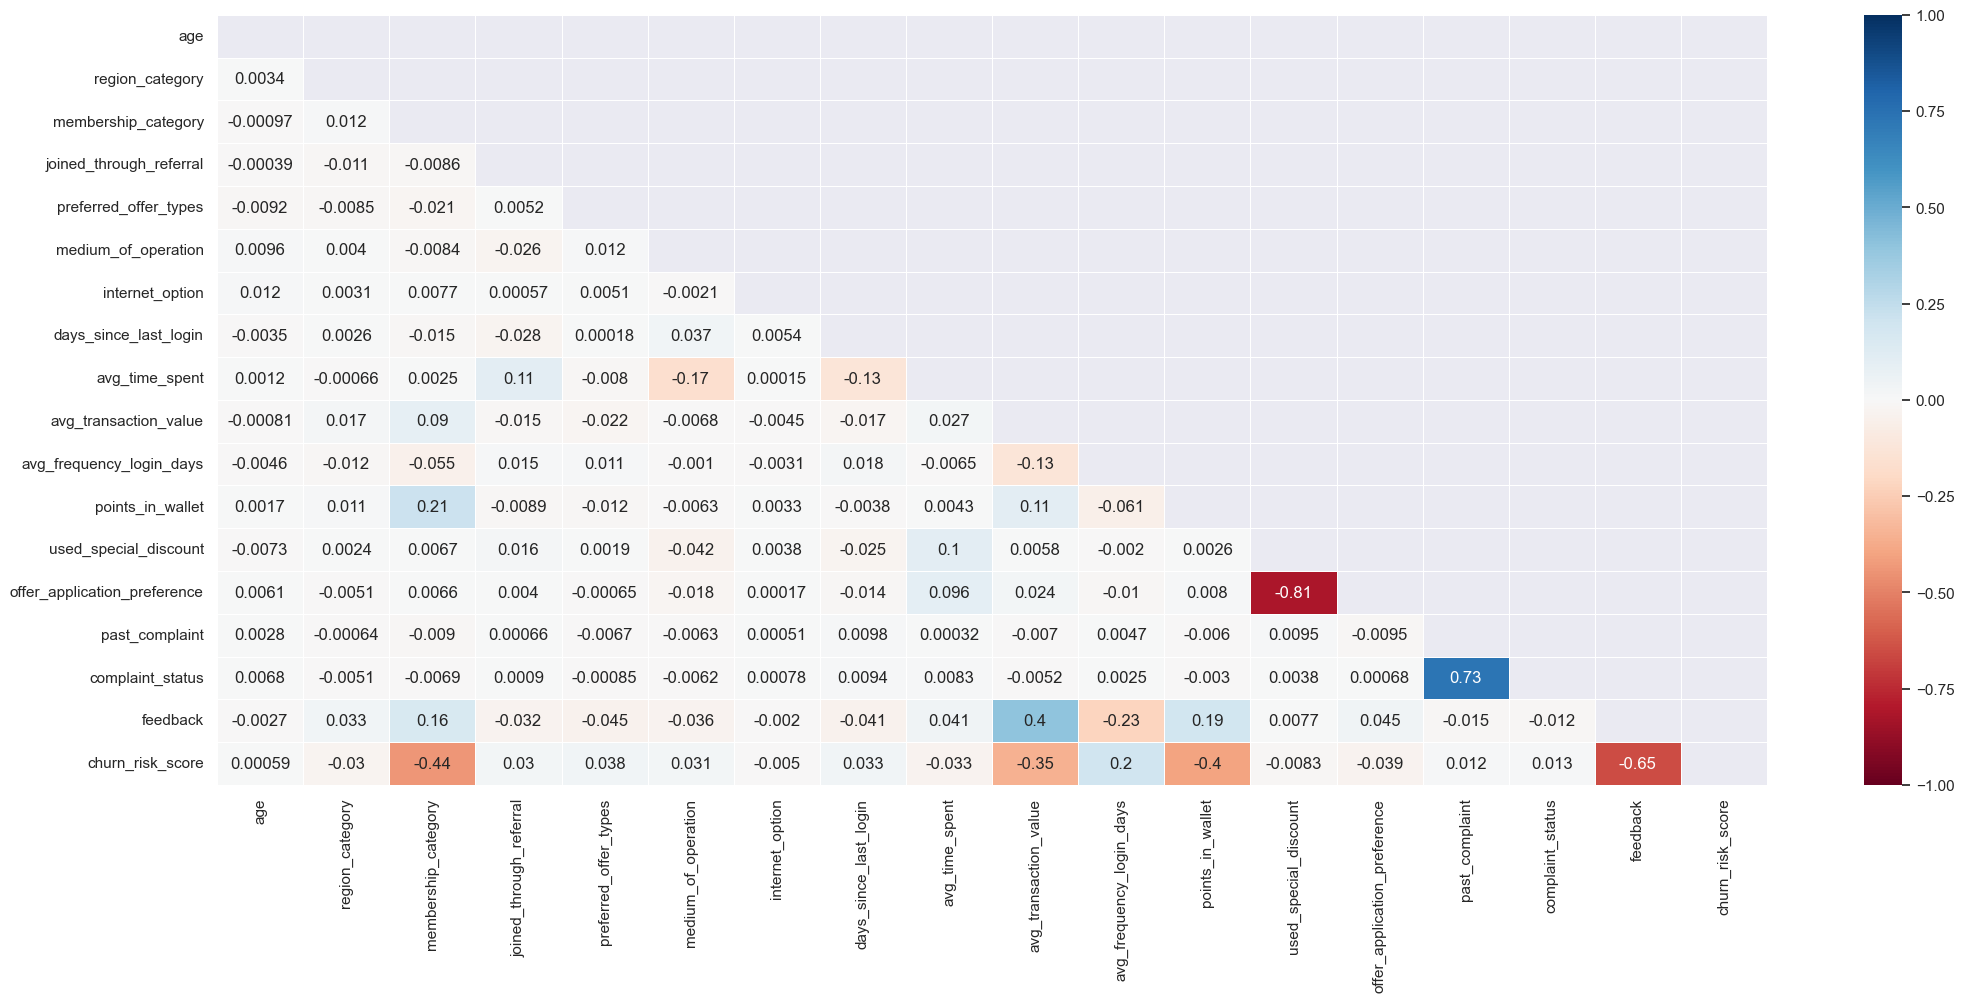

In [31]:
# Show heatmap after normalized data
corr = df.corr()
plt.figure(figsize = (25, 10))
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr,mask=mask,cmap='RdBu', vmin=-1, vmax= 1 , center=0, annot=True,linewidth=0.5)

<AxesSubplot:title={'center':'Correlation Between Target based on All Features'}>

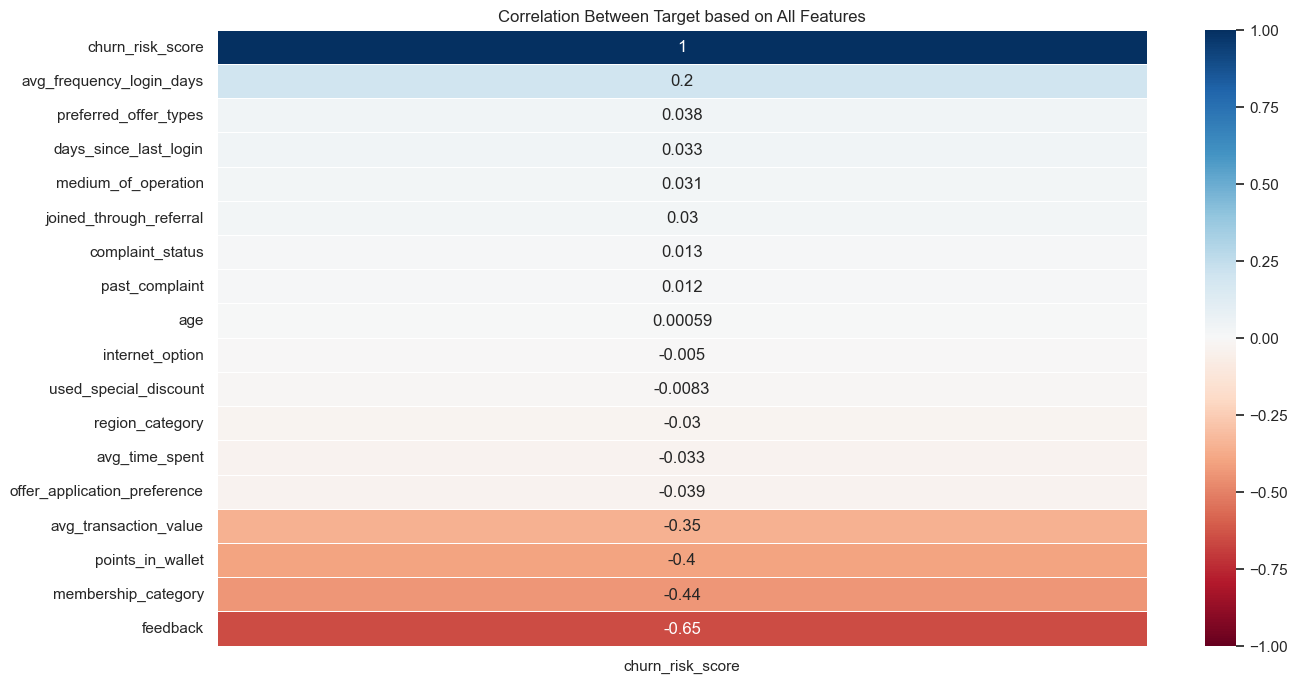

In [32]:
plt.figure(figsize=(15,8))
plt.title('Correlation Between Target based on All Features')
sns.heatmap(df.corr()[['churn_risk_score']].sort_values(by='churn_risk_score', ascending=False),cmap='RdBu', vmin=-1, vmax= 1 , center=0, annot=True,linewidth=.5,square=False)

In [33]:
# Checking skewness of numerical features
df[numerical_cols].skew().to_frame().rename(columns={0:"Feature Skewness"})

,Feature Skewness
age,-0.006034
days_since_last_login,0.025840
avg_time_spent,1.115534
avg_transaction_value,0.762433
avg_frequency_login_days,0.021584
points_in_wallet,-0.035647
churn_risk_score,-0.575052


In [34]:
# avg_time_spent_save = df['avg_time_spent']
# avg_transaction_value_save = df['avg_transaction_value']

In [35]:
# df['avg_time_spent'] = np.log(df['avg_time_spent'])
# df['avg_transaction_value'] = np.log(df['avg_transaction_value'])

In [36]:
# plt.figure(figsize=(13,6))
# plt.subplot(1,2,1)
# sns.histplot(avg_time_spent_save, color="purple", kde=True)
# plt.title("Before Transformation",fontweight="black",size=18,pad=20)

# plt.subplot(1,2,2)
# sns.histplot(df['avg_time_spent'], color="purple", kde=True)
# plt.title("After Transformation",fontweight="black",size=18,pad=20)
# plt.tight_layout()
# plt.show()

In [37]:
# plt.figure(figsize=(13,6))
# plt.subplot(1,2,1)
# sns.histplot(avg_transaction_value_save, color="purple", kde=True)
# plt.title("Before Transformation",fontweight="black",size=18,pad=20)

# plt.subplot(1,2,2)
# sns.histplot(df['avg_transaction_value'], color="purple", kde=True)
# plt.title("After Transformation",fontweight="black",size=18,pad=20)
# plt.tight_layout()
# plt.show()

In [38]:
df.isnull().sum()

age                             0
region_category                 0
membership_category             0
joined_through_referral         0
preferred_offer_types           0
medium_of_operation             0
internet_option                 0
days_since_last_login           0
avg_time_spent                  0
avg_transaction_value           0
avg_frequency_login_days        0
points_in_wallet                0
used_special_discount           0
offer_application_preference    0
past_complaint                  0
complaint_status                0
feedback                        0
churn_risk_score                0
dtype: int64

<div style="border-radius:10px; border:#808080 solid; padding: 15px; background-color: ##F0E68C ; font-size:100%; text-align:left">

<h3 align="left"><font>📊 Note:</font></h3>

    
* `avg_time_spent` is highly right-skewed, which conveys that there is presence of **positive outliers**
* The same thing comes to `avg_transaction_value`

# **Model Training**

In [39]:
def prepare_X_y(df):
    X = df.drop('churn_risk_score', axis = 1)
    y = df['churn_risk_score']
    return X, y

X, y = prepare_X_y(df)

## Dividing the dataset into training and test sets

In [40]:
RANDOM_STATE = 7
TRAIN_SIZE = 0.8

X_train, X_test ,y_train, y_test = train_test_split(X, y, train_size=TRAIN_SIZE, random_state=RANDOM_STATE)

## 	Balance Data

In [41]:
from imblearn.over_sampling import RandomOverSampler, SMOTE
# Apply SMOTE to the training set
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

## Model Training & Evaluation

In [42]:
print(f'The number of records in training set is {X_train.shape[0]}')
y_train.value_counts(). to_frame()

The number of records in training set is 37725


,count
churn_risk_score,
4,7545
5,7545
3,7545
2,7545
1,7545


<div style="border-radius:10px; border:#808080 solid; padding: 15px; background-color: ##F0E68C ; font-size:100%; text-align:left">

* **Both the categories** in Target variable are now having **equal number of records.**
* So let's **train the Model** and make a predictive model with **Support Vector Machine Classifier**

<div class="list-group" id="list-tab" role="tablist">
    <h3 style="text-align: left; background-color: #ACA224; font-family:Tahoma; color: white; padding: 14px; line-height: 1; border-radius:10px"><b>SUPPORT VECTOR MACHINE 📝</b></h3>

### *Support Vector Classifier Using SMOTE, StandardScaler, and SVC*

In [43]:
# Create a pipeline with SMOTE, StandardScaler, and SVC
pipeline = Pipeline([
    ('scaler', StandardScaler()), # Feature Scaling
    ('svm', SVC()) # Model
])

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

# Make predictions on the testing data
svm_pred = pipeline.predict(X_test)

# Evaluate the model
print(classification_report(y_test, svm_pred))

accuracy_svc = pipeline.score(X_test, y_test)
print(f"SVM accuracy is: {round(accuracy_svc * 100, 2)}%")

              precision    recall  f1-score   support

           1       0.67      0.62      0.65       498
           2       0.65      0.69      0.67       500
           3       0.76      0.82      0.79      1872
           4       0.56      0.52      0.54      1817
           5       0.65      0.65      0.65      1775

    accuracy                           0.66      6462
   macro avg       0.66      0.66      0.66      6462
weighted avg       0.66      0.66      0.66      6462

SVM accuracy is: 66.4%


### **Hyperparameter Tuning for SVC**

In [44]:
# scaler = StandardScaler()
# features = X_train.columns
# X_train = pd.DataFrame(scaler.fit_transform(X_train.values), columns=features)
# # Apply the same scaler to the testing set
# X_test = pd.DataFrame(scaler.transform(X_test), columns = features)

In [45]:
# Create a pipeline with preprocessing steps and SVC classifier
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', SVC())
])

# Define the parameter grid for grid search
param_grid = {
    'classifier__C': [0.1, 1, 10],
    'classifier__kernel': ['linear', 'rbf']
}

# Create a GridSearchCV object with the pipeline and parameter grid
grid_search = GridSearchCV(pipe, param_grid, cv=5)

# Fit the grid search on the data
grid_search.fit(X_train, y_train)

# Access the best parameters and best score found during the grid search
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Print the best parameters and best score
print("Best Parameters:", best_params)
print("Best Score:", best_score)


# Predict the label for the test set using the best model
best_model = grid_search.best_estimator_
print('Best Model: ', best_model)
y_pred = best_model.predict(X_test)

print(classification_report(y_test, y_pred))

# Model evaluation
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Print the result
print("Accuracy:", round(accuracy*100, 2), "%")
print("Precision:", round(precision*100, 2), "%")
print("Recall:", round(recall*100, 2), "%")
print("F1-score:", round(f1*100, 2), "%")

Best Parameters: {'classifier__C': 10, 'classifier__kernel': 'rbf'}
Best Score: 0.7193638170974156
Best Model:  Pipeline(steps=[('scaler', StandardScaler()), ('classifier', SVC(C=10))])
              precision    recall  f1-score   support

           1       0.64      0.59      0.61       498
           2       0.62      0.67      0.64       500
           3       0.79      0.82      0.81      1872
           4       0.58      0.56      0.57      1817
           5       0.65      0.65      0.65      1775

    accuracy                           0.67      6462
   macro avg       0.66      0.66      0.66      6462
weighted avg       0.67      0.67      0.67      6462

Accuracy: 67.15 %
Precision: 66.92 %
Recall: 67.15 %
F1-score: 67.01 %


> GridSearchCV can be computationally expensive and time-consuming, especially with large search spaces, while RandomizedSearchCV is more efficient in terms of resources and time. Hence, use RandomizedSearchCV to find the optimal hyperparameters

<div class="list-group" id="list-tab" role="tablist">
    <h3 style="text-align: left; background-color: #ACA224; font-family:Tahoma; color: white; padding: 14px; line-height: 1; border-radius:10px"><b>DECISION TREE 📝</b></h3>

In [47]:
# Create a pipeline with preprocessing steps and SVC classifier
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', DecisionTreeClassifier())
])

# Define the parameter grid for grid search
param_grid = {
    "classifier__max_depth":[3,4,5,6,7,8,9,10],
		"classifier__min_samples_split":[2,3,4,5,6,7,8],
		"classifier__min_samples_leaf":[1,2,3,4,5,6,7,8],
		"classifier__criterion":["gini","entropy"],
		"classifier__splitter":["best","random"],
		"classifier__max_features":["auto",None],
		"classifier__random_state":[0,42]
}

# Create a GridSearchCV object with the pipeline and parameter grid
grid_search = GridSearchCV(pipe, param_grid, cv=5, n_jobs = -1)

# Fit the grid search on the data
grid_search.fit(X_train, y_train)

grid_search

# Access the best parameters and best score found during the grid search
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Print the best parameters and best score
print("Best Parameters:", best_params)
print("Best Score:", best_score)

# Predict the label for the test set using the best model
best_model = grid_search.best_estimator_
print('Best Model: ', best_model)
y_pred = best_model.predict(X_test)

print(classification_report(y_test, y_pred))

# Model evaluation
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Print the result
print("Accuracy:", round(accuracy*100, 2), "%")
print("Precision:", round(precision*100, 2), "%")
print("Recall:", round(recall*100, 2), "%")
print("F1-score:", round(f1*100, 2), "%")

Best Parameters: {'classifier__criterion': 'gini', 'classifier__max_depth': 9, 'classifier__max_features': None, 'classifier__min_samples_leaf': 8, 'classifier__min_samples_split': 2, 'classifier__random_state': 42, 'classifier__splitter': 'best'}
Best Score: 0.7797746852220013
Best Model:  Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier',
                 DecisionTreeClassifier(max_depth=9, min_samples_leaf=8,
                                        random_state=42))])
              precision    recall  f1-score   support

           1       0.75      0.79      0.77       498
           2       0.78      0.74      0.76       500
           3       0.90      0.91      0.91      1872
           4       0.74      0.53      0.62      1817
           5       0.71      0.90      0.79      1775

    accuracy                           0.78      6462
   macro avg       0.78      0.78      0.77      6462
weighted avg       0.78      0.78      0.77      6462

Accuracy:

In [48]:
y_train_pred = grid_search.predict(X_train)
y_test_pred = grid_search.predict(X_test)

print("Accuracy Score of Model on Training Data is =>",round(accuracy_score(y_train, y_train_pred)*100,2),"%")
print("Accuracy Score of Model on Testing Data  is =>",round(accuracy_score(y_test, y_test_pred)*100,2),"%")

Accuracy Score of Model on Training Data is => 80.61 %
Accuracy Score of Model on Testing Data  is => 78.1 %


### **Importance of Features in DecisionTreeClassifier**

In [49]:
# Get feature importances
feature_importances = best_model.named_steps['classifier'].feature_importances_

imp_df = pd.DataFrame({"Feature Name":X_train.columns,
                      "Importance":feature_importances})

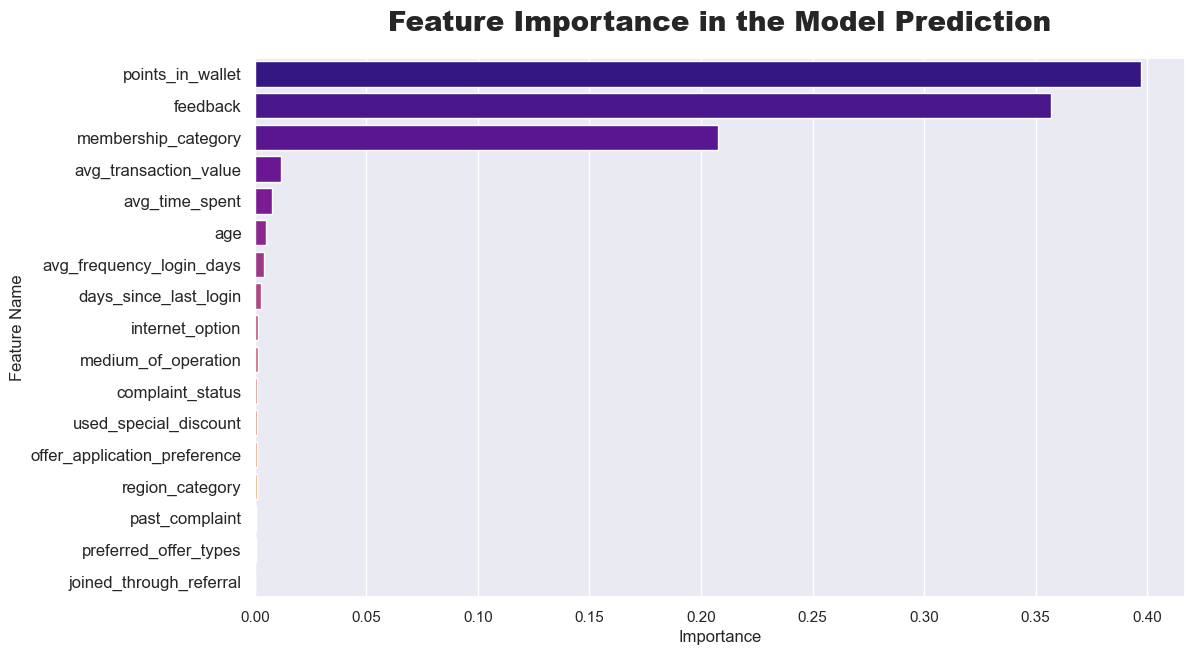

In [50]:
features = imp_df.sort_values(by="Importance",ascending=False)

plt.figure(figsize=(12,7))
sns.barplot(x="Importance", y="Feature Name", data=features, palette="plasma")
plt.title("Feature Importance in the Model Prediction", fontweight="black", size=20, pad=20)
plt.yticks(size=12)
plt.show()

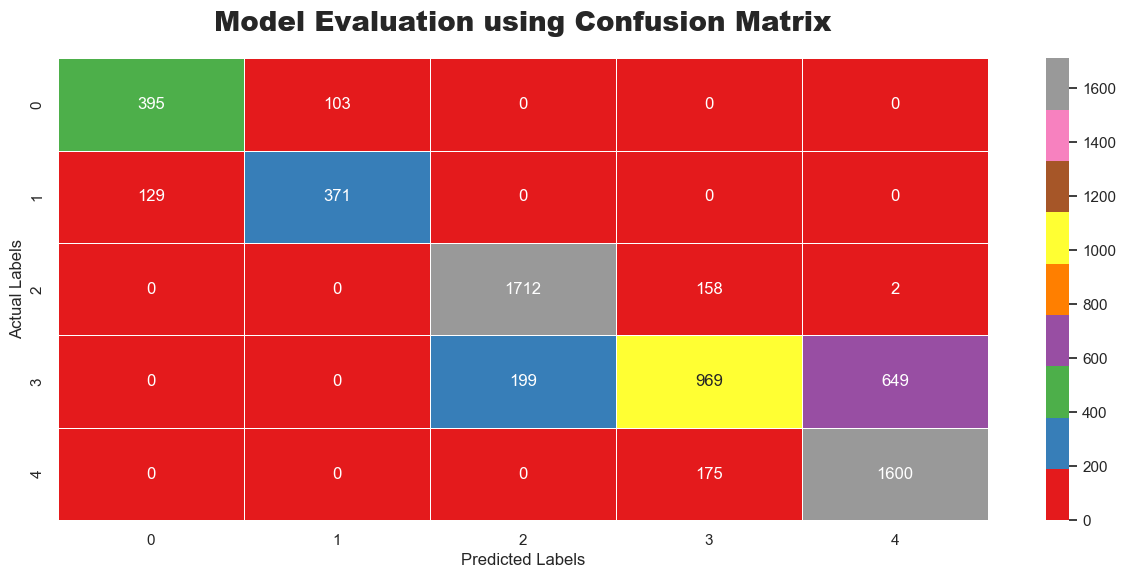

In [51]:
cm = confusion_matrix(y_test,y_test_pred)

plt.figure(figsize=(15,6))
sns.heatmap(data=cm, linewidth=.5, annot=True, fmt="g", cmap="Set1")
plt.title("Model Evaluation using Confusion Matrix",fontsize=20,pad=20,fontweight="black")
plt.ylabel("Actual Labels")
plt.xlabel("Predicted Labels")
plt.show()

<div style="border-radius:10px; border:black solid; padding: 15px; background-color: #E9F7EF; font-size:100%; text-align:left">
<p style="font-family:Georgia; font-weight:bold; letter-spacing: 2px; color:black; font-size:300%; text-align:center;padding: 0px;"> Conclusion</p></div>

<div style="border-radius:10px; border:#808080 solid; padding: 15px; background-color: ##F0E68C ; font-size:100%; text-align:left">

<h3 align="left"><font color=green>📊 Key-Points</font></h3>

    
* The **key factors** that significantly influence the **customer churn rate** are **points_in_wallet, feedback** and **Membership Category**

* This dataset is really bad. Hence the model result is also pretty low. The main reason is data collection.

<h3 align="left"><font color=green>📊 Recommendations</font></h3>

1. The **bank** can try to convince the customers to have **at least 2 banking products** but **not less than 2.**
2. The **bank** can launch a **Scheme or Event for customers with higher ages** so that they will not cancel their **banking facilities.**
3. The **bank** can provide some cervices to connect to their customer by **Rewards and Incentive Programs** or **Regular Communication and Updates** so that customers remain active to the banking facilities.